In [1]:
import numpy as np
import tensorflow as tf
from glob import glob
import IPython
import time
import librosa
import os
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import torchaudio

2022-03-02 15:52:47.728350: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 15:52:47.728373: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
hop=256               #hop size (window size = 4*hop)
sr=16000             #sampling rate
min_level_db=-100     #reference values to normalize data
ref_level_db=20


shape=128           #length of time axis of split specrograms         
spec_split=1

In [3]:
import torch
from torchaudio.transforms import MelScale, Spectrogram

torch.set_default_tensor_type('torch.FloatTensor')

specobj = Spectrogram(n_fft=4*hop, win_length=4*hop, hop_length=hop, pad=0, power=2, normalized=False)
specfunc = specobj.forward

def melspecfunc(waveform):
  specgram = specfunc(waveform)
  #mel_specgram = melfunc(specgram)
  #return mel_specgram
  return specgram

def normalize(S):
  return np.clip((((S - min_level_db) / -min_level_db)*2.)-1., -1, 1)

def prep(wv, hop=192):
  S = np.array(torch.squeeze(melspecfunc(torch.Tensor(wv).view(1,-1))).detach().cpu())
  S = librosa.power_to_db(S)-ref_level_db
  return normalize(S)


In [4]:
#Generate spectrograms from waveform array
def tospec(data):
  spectro = []
  for awv in data:
    spec = prep(awv)
    spectro.append(spec)
  return np.array(spectro, dtype=np.float32)
    

#Waveform array from path of folder containing wav files
def audio_array(path):
  ls = glob(f'{path}/*.wav')
  adata = []
  for i in range(len(ls)):
    x, sr = tf.audio.decode_wav(tf.io.read_file(ls[i]), 1)
    x = np.array(x, dtype=np.float32)

    time = 1
    length = len(x)/sr

    while time < length:
      adata.append(x[(time-1)*sr:time*sr])
      time += 1

  return np.array(adata)

In [6]:
audio_directory = "./Dataset/wav/female"
array_file = './Dataset/array/female'

#get waveform array from folder containing wav files
awv = audio_array(audio_directory)

#get spectrogram array
aspec = tospec(awv)

print(aspec.shape)

np.save(array_file,aspec)

(2822, 513, 63)


# Method with pytorch

In [ ]:
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram_from_wave(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = np.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

In [ ]:
import torchaudio

SAMPLE_WAV_SPEECH_PATH = "./Dataset/wav/female/arctic_a0001.wav"


waveform, sample_rate = torchaudio.load(SAMPLE_WAV_SPEECH_PATH)
print(np.shape(waveform))
plt.clf()
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram_from_wave(waveform, sample_rate)
#play_audio(waveform, sample_rate)

In [7]:
def plot_specgram(spec, sample_rate, title="Spectrogram", xlim=None):
  num_freq, num_frames = spec.shape
  time_axis = np.arange(0, num_frames) / sample_rate
  freq_axis = np.arange(0, num_freq) * sample_rate/2/num_freq
  figure, axes = plt.subplots(1, 1)
  axes.pcolormesh(time_axis, freq_axis, spec[:,:], cmap='viridis')
  axes.set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

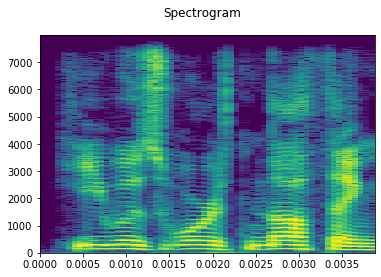

In [8]:
data = np.load('./Dataset/array/male.npy', allow_pickle=True)

data[0].shape

plot_specgram(data[0], sr)